## Show results - Test 

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../figures/'

In /Users/zeliestalhanske/anaconda3/envs/climada_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/zeliestalhanske/anaconda3/envs/climada_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/zeliestalhanske/anaconda3/envs/climada_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/zeliestalhanske/anaconda3/envs/climada_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.

2020-10-27 14:55:41,387 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/Documents/GitHub/climada_python/climada/conf/defaults.conf


## Damage cost for each scenario, year and labor type

In [2]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices


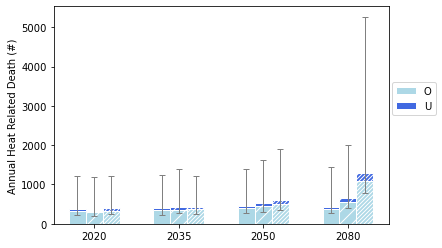

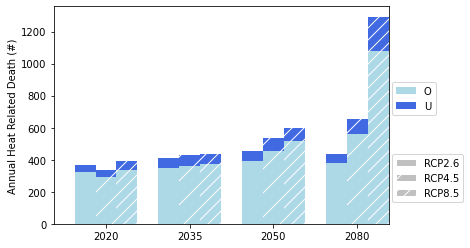

In [3]:
plot_impacts_heat(agg_impacts_mc, 'Annual Heat Related Death (#)', color=['lightblue', 'royalblue'])

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065_werror.pdf']),bbox_inches='tight')


## Spatial Impact

In [4]:
category = 'O'
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

directory_exposures = '../../input_data/exposures/'
exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', category, '.h5'])
exposures = Exposures()
exposures.read_hdf5(exposures_file)
impact = impacts_mortality.median_matrix_as_impact(median_impact_matrices['RCP85'][2020]['U'], exposures, unit='Annual Heat Related Death (#)', percentage=False)
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

2020-10-27 14:55:43,821 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5


In [5]:
impact = impacts_mortality.median_matrix_as_impact(median_impact_matrices['RCP85'][2020]['U'], exposures, unit='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Relative change map

In [8]:
impacts_rel = Impact()
impacts_rel_2050_rcp85 = ImpactsHeatMortality.compute_relative_change(median_impact_matrices['RCP85'][2050]['U'], median_impact_matrices['RCP85'][2020]['U'])
impacts_rel_2050_rcp85.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Canton Impacts

In [7]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices

directory_exposures = '../../input_data/exposures/'
exposures = {}
for category in ['O', 'U']:
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_',category,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()

agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Zürich', exposures)

2020-10-27 14:50:12,784 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-10-27 14:50:14,447 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-27 14:50:14,448 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-27 14:50:14,449 - climada.entity.exposures.base - INFO - cover not set.
2020-10-27 14:50:14,449 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-27 14:50:14,450 - climada.entity.exposures.base - INFO - region_id not set.
2020-10-27 14:50:14,451 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-10-27 14:50:16,210 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-27 14:50:16,211 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-27 14:50:16,212 - climada.entity.exposures.base - INFO - cover not set.
2020-10-27 14:50:16,212 - climada.entity.exposures.base - INFO - category_id not s

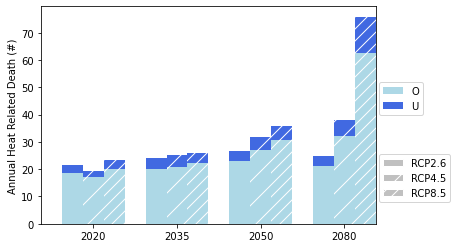

In [8]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)',uncertainty=False, color=['lightblue', 'royalblue'])